In [36]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [37]:
def new_positions_spherical_coordinates(num_points, radius, x_offset=0.0, y_offset=0.0, z_offset=0.0, stddev=0.0):
    radius = radius + stddev * np.random.rand()
    print(radius)
    theta = np.random.uniform(0.,2. * np.pi ,(num_points,1))
    phi = np.arccos(1-2*np.random.uniform(0.0,1.,(num_points,1)))
    x = radius * np.sin( theta ) * np.cos( phi ) + x_offset + stddev * np.random.rand()
    y = radius * np.sin( theta ) * np.sin( phi ) + y_offset + stddev * np.random.rand()
    z = radius * np.cos( theta ) + z_offset + stddev * np.random.rand()
    return (x,y,z)

In [38]:
np.set_printoptions(precision=4)

In [66]:
# Generate random point set
r = 10.0
n = 10
(x,y,z) = new_positions_spherical_coordinates(n, r,
                                              x_offset=0.0,
                                              y_offset=0.0,
                                              z_offset=0.0, 
                                              stddev=0.0)
# print(x)
# print(y)
# print(z)

10.0


In [40]:
# Point set from Hildenbrand
# n = 5
# x = [1.0, 1.0, 0.0, 0.0, -1.0]
# y = [0.0, 1.0, 0.0, 1.0,  0.0]
# z = [0.0, 0.0, 1.0, 1.0,  1.0]

In [41]:
ps = [np.array(np.ravel(p).tolist() + 
               [1.0, 0.5*np.linalg.norm(p)**2]).reshape(5,1) 
      for p in zip(x,y,z)]

## Total Least Squares Fitting of $k$-Spheres in $n$-D Euclidean Space Using an $(n + 2)$-D Isometric Representation

Leo Dorst 2014

Journal of Mathematical Imaging and Vision

http://link.springer.com/article/10.1007%2Fs10851-014-0495-2


Cost function:
$$\frac{1}{N}\sum_i\frac{(p_i \cdot x)^2}{x^2}$$

In [42]:
M = np.zeros((5,5))
M[:3,:3] = np.eye(3)
M[3,4] = -1
M[4,3] = -1
P = np.zeros((5,5))
for p in ps:
    P += np.inner(np.outer(p,p),M)
(w,v) = np.linalg.eig(P / float(len(ps)))
idx = np.where(w == np.min(w[w>0]))[0][0]
x_ = v[:,idx]
x_ /= x_[3]
x_dorst = x_.copy()
print(x_)
radius = np.sqrt(x_[0]*x_[0] + x_[1]*x_[1] + x_[2]*x_[2] - 2*x_[4])
print("Estimated radius: {}".format(radius))

[-1.6929  3.7661 -2.2026  1.      4.5   ]
Estimated radius: 3.59178160795


In [43]:
# M

In [44]:
# P

## Foundations of Geometric Algebra Computing

Dietmar Hildenbrand 2013

In [45]:
P = np.zeros((5,5))
for p in ps:
    P += np.outer(p,p)
(w,v) = np.linalg.eig(P)
idx = np.where(w == np.min(w[w>0]))[0][0]
x_ = v[:,idx]
x_ /= x_[4]
print(x_)
radius = np.sqrt(x_[0]*x_[0] + x_[1]*x_[1] + x_[2]*x_[2] - 2*x_[3])
print("Estimated radius: {}".format(radius))

[ 0.8897 -1.9643  1.1449  0.2222  1.    ]
Estimated radius: 2.34867710585


In [46]:
# P

In [47]:
import sys
sys.path.append('../build/Debug/')
import libsphere_fit as sphere_fit

In [104]:
def create_solver_options(use_trust_region_minimizer=True):
    solver_options = {
        'minimizer_type':'TRUST_REGION',
#                 'minimizer_type':'LINE_SEARCH',
                      'trust_region_strategy_type':'LEVENBERG_MARQUARDT',
                      'linear_solver_type':'DENSE_QR',
                      'max_num_iterations': 100, 
                      'num_threads': 12,
                      'num_linear_solver_threads':12,
                      'parameter_tolerance': 10e-8,
                      'function_tolerance': 10e-8,
                      'minimizer_progress_to_stdout':False,
                      'trust_region_minimizer_iterations_to_dump':[],
                      'trust_region_problem_dump_directory':'/home/lars/devel/game_ws/dump/sphere_fit',
                     }
    return solver_options    

In [105]:
sf = sphere_fit.SphereFit()

solver_options = create_solver_options()
# solver_options['minimizer_progress_to_stdout'] = True
# solver_options['trust_region_minimizer_iterations_to_dump'] = [1,2,3,4,5,6,7,8,9]
sf.set_solver_options(solver_options)


sphere = np.array([1.0, 1.0, 1.0, 1.0, 1.0]).reshape(5,1)
points = np.ascontiguousarray(np.transpose([x,y,z])).reshape(n,3).copy()
x_ = sf.run(sphere, points).copy()

x_ = x_ / x_[3]
print(x_.reshape(-1))
radius = np.sqrt(x_[0]*x_[0] + x_[1]*x_[1] + x_[2]*x_[2] - 2*x_[4])[0]
print("Estimated radius: {}".format(radius))

[  4.8854e-07   1.1274e-07   5.5436e-08   1.0000e+00  -5.0000e+01]
Estimated radius: 9.99999985781


In [69]:
np.linalg.norm(sphere)
x_dorst

array([-1.6929,  3.7661, -2.2026,  1.    ,  4.5   ])

[4.960630275356303, 3.0658381157919457]


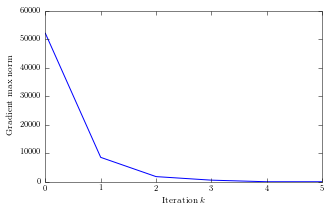

In [107]:
# matplotlib.rc?
scale = 1.0
fig_width_pt = 358.50475  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (sqrt(5.0)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]
print fig_size
params = {
    'axes.labelsize': 9,
    'font.size': 9,
#           "font.family": "sans-serif",
#           "font.sans-serif": [],
          "font.family": "serif",
          "font.serif": [],
          'legend.fontsize': 9,
          'legend.linewidth': 0.3,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': True,
          'figure.figsize': fig_size,
          'axes.linewidth': 0.5
         }
 
 
matplotlib.rcParams.update(params)
iterations = sf.summary()['iterations']
plt.plot([iteration['gradient_max_norm'] for iteration in iterations])

plt.xlabel('Iteration $k$')
plt.ylabel('Gradient max norm')
plt.xticks([iteration['iteration'] for iteration in iterations])
save_dir = '/home/lars/Dropbox/sharelatex/2016_phd_thesis_lt/figures'
plt.savefig(save_dir + '/sphere_fit_gradient.pdf')

In [52]:
sphere.reshape(-1)

array([  4.7440e-08,  -1.0486e-07,   6.1018e-08,   1.0905e+00,  -4.9071e+00])

In [71]:
print(sf.summary()['full_report'])


Solver Summary (v 1.10.0-eigen-(3.2.0)-lapack-suitesparse-(4.2.1)-openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  5                        5
Residual blocks                            10                       10
Residual                                   10                       10

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                    12                       12
Linear solver threads                      12                       12

Cost:
Initial                          1.332798e+04
Final                            9.106761e-14
Change                           1.332798e+04

In [54]:
"a\\r\\nb"

'a\\r\\nb'

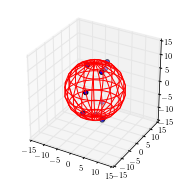

In [78]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect("equal")
u, v = np.mgrid[0:2*np.pi:20j, 0:-np.pi:10j]
sx= r * np.cos(u)*np.sin(v)
sy= r * np.sin(u)*np.sin(v)
sz= r * np.cos(v)
ax.plot_wireframe(sx, sy, sz, color="r")

ax.scatter3D(x,y,z)
# sx= radius * np.cos(u)*np.sin(v) + x_[0]
# sy= radius * np.sin(u)*np.sin(v) + x_[1]
# sz= radius * np.cos(v) + x_[2]
# ax.plot_wireframe(sx, sy, sz, color="b")
plt.savefig('sphere_fit.pdf')

In [56]:
def load_problem_iteration_dump(directory, iteration):
    tmp = '/ceres_solver_iteration_{:0>3d}'.format(iteration)
    D = np.loadtxt(directory + tmp + '_D.txt')
    b = np.loadtxt(directory + tmp + '_b.txt')
    x = np.loadtxt(directory + tmp + '_x.txt')
    f = open(directory + tmp + '.m')
    matlab_script = f.readlines()
    f.close()
    rows = [int(s) for s in matlab_script[1][:-2].split() if s.isdigit()][0]
    cols = [int(s) for s in matlab_script[2][:-2].split() if s.isdigit()][0]
    A_sparse = np.loadtxt(directory + tmp + '_A.txt')
    A = np.zeros((rows, cols))
    for row in A_sparse:
        A[int(row[0]), int(row[1])] = row[2]
    return (A,D,b,x)

directory = solver_options['trust_region_problem_dump_directory']
(A, D, b, x_) = load_problem_iteration_dump(directory, 1)
A

array([[ 0.0702,  0.0653,  0.0597, -0.0956, -0.0651],
       [ 0.0673,  0.0618,  0.066 , -0.0955, -0.0642],
       [ 0.0629,  0.0639,  0.0648, -0.0945, -0.0567],
       [ 0.07  ,  0.0595,  0.0621, -0.0947, -0.0578],
       [ 0.066 ,  0.0671,  0.0579, -0.0945, -0.0562],
       [ 0.0689,  0.0683,  0.0577, -0.0956, -0.0645],
       [ 0.0636,  0.0637,  0.064 , -0.0945, -0.0563],
       [ 0.0696,  0.0683,  0.0564, -0.0954, -0.0635],
       [ 0.0664,  0.0597,  0.0668, -0.0949, -0.0595],
       [ 0.0707,  0.059 ,  0.0627, -0.0948, -0.0591]])

In [57]:
D

array([ 0.0021,  0.002 ,  0.0019,  0.003 ,  0.0019])